<a href="https://colab.research.google.com/github/m-riddle-codes/ARA/blob/main/005_pd1pdl1_mcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi

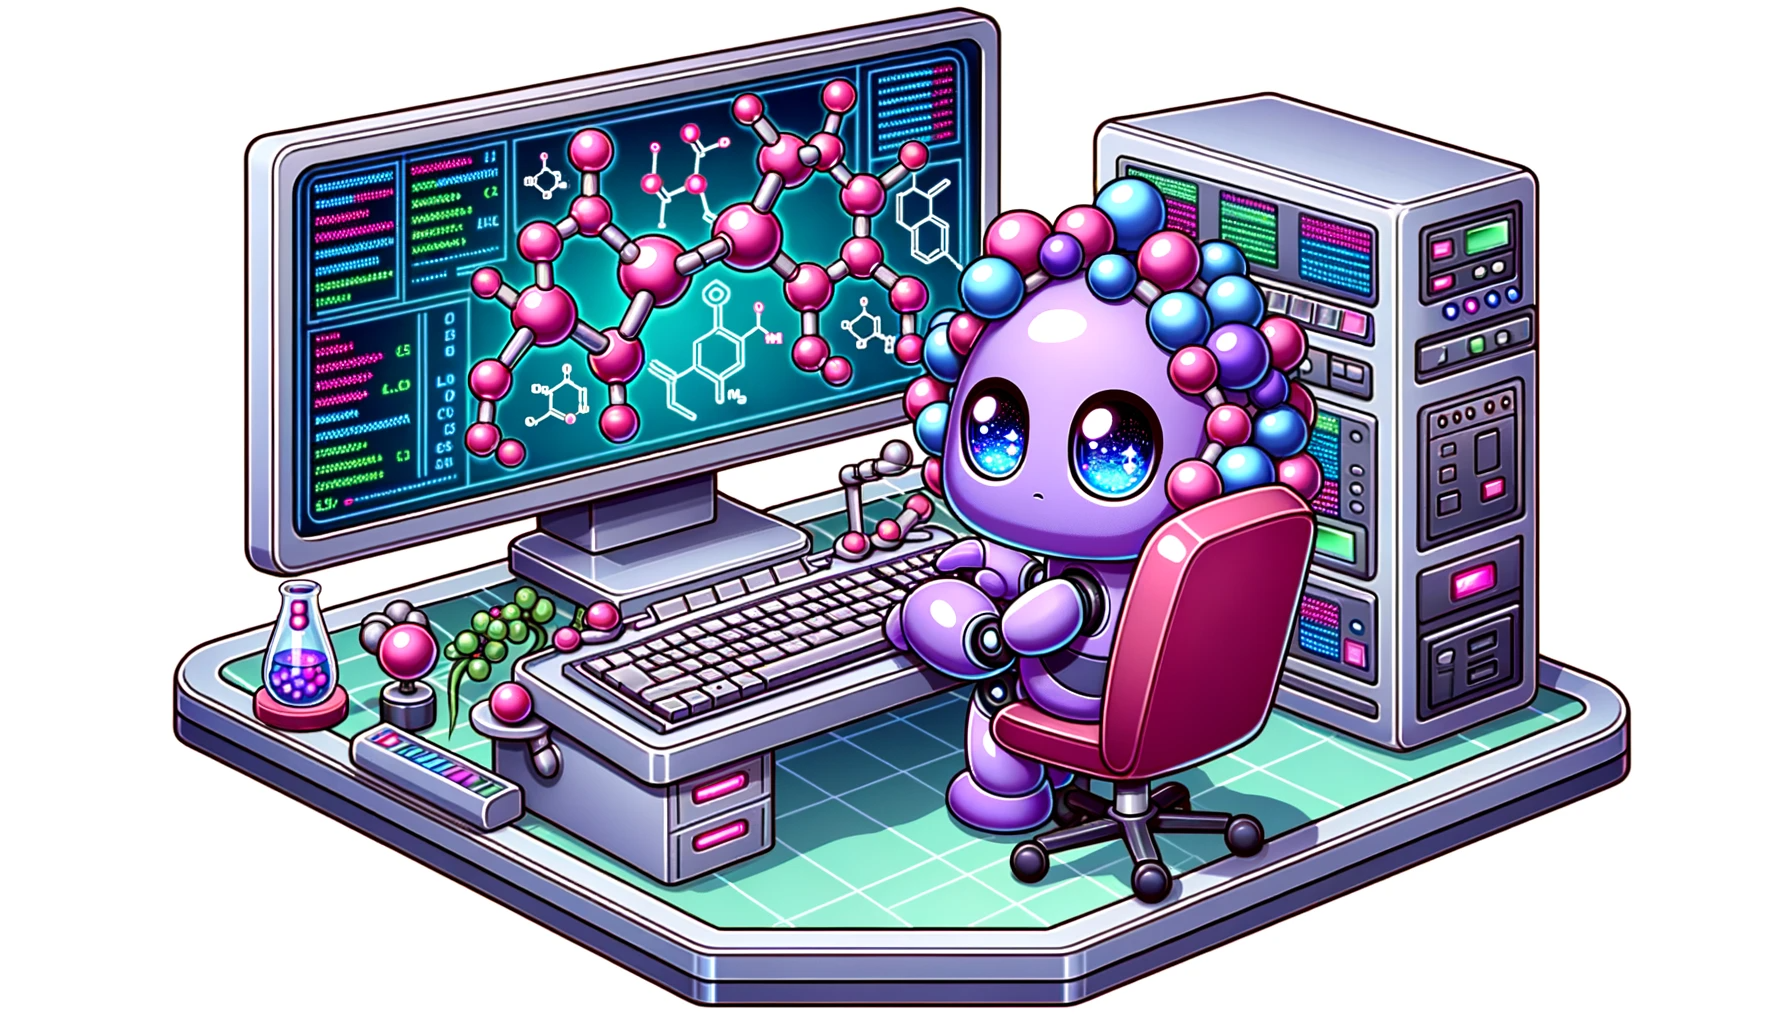

In [ ]:
# @title Default title text
from IPython.display import Image
Image(filename='mcs.png')

In [ ]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

In [ ]:
def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import os
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything()

In [ ]:
sdf = str("pd1pdl1.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")
# NBVAL_CHECK_OUTPUT

Set with 31 molecules loaded.


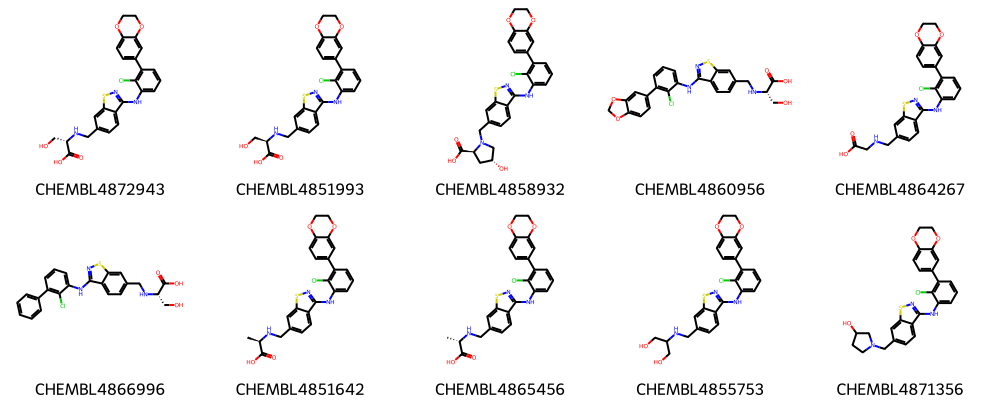

In [ ]:
# Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

Run the FMCS algorithm with different input parameters

In [ ]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 22 atoms and 25 bonds.
MCS SMARTS string: [#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#16]:[#7]:[#6]:2-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


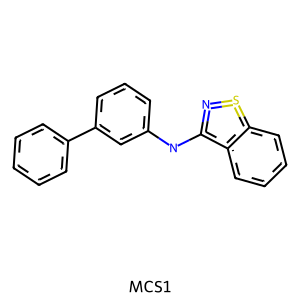

In [ ]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

Define a helper function to draw the molecules with the highlighted MCS.

In [ ]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

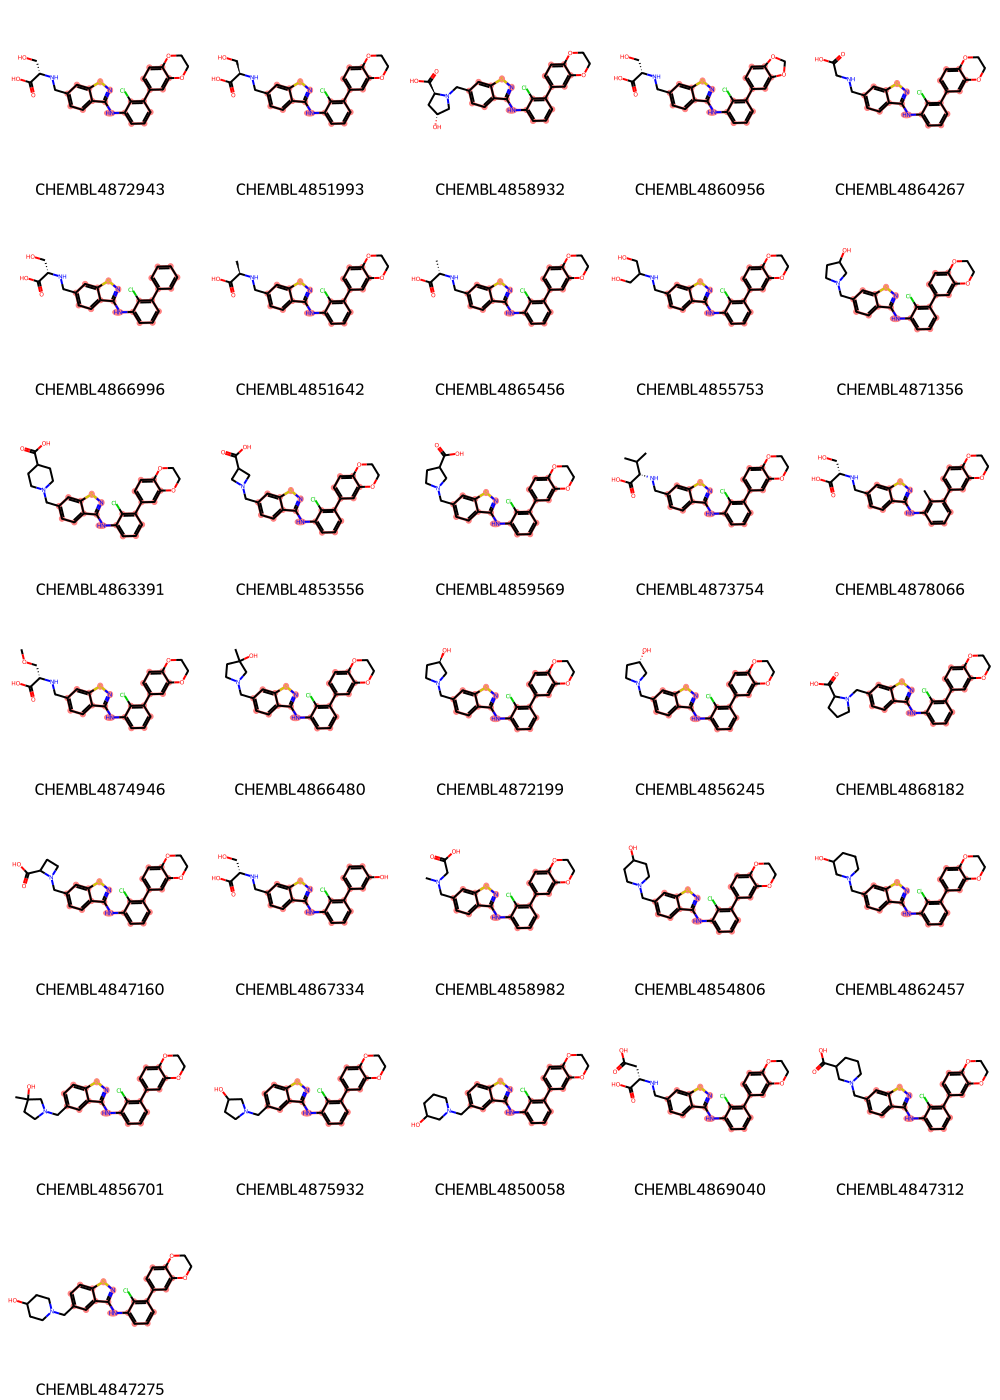

In [ ]:
highlight_molecules(mols, mcs1, 46)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

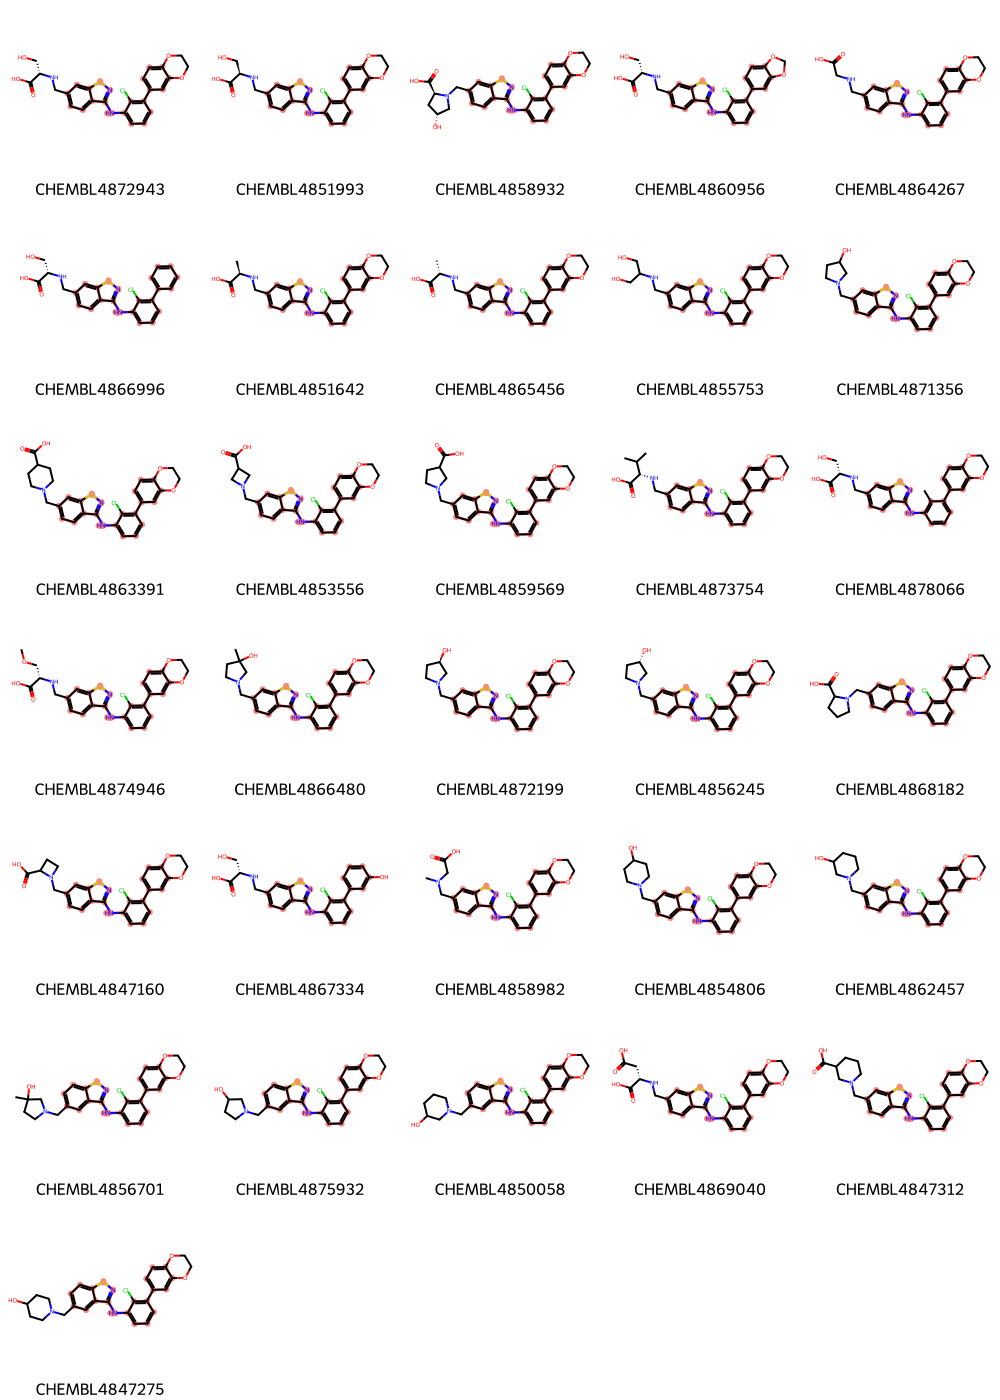

In [ ]:
# Assuming you've already defined or imported the `highlight_molecules` function
img = highlight_molecules(mols, mcs1, 46, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to a file in Colab's temporary storage
file_path = "/content/mcs_largest_cluster1.svg"
with open(file_path, "w") as f:
    f.write(molsvg)

# If you want to download the SVG to your local machine:
from google.colab import files
files.download(file_path)

# To display the SVG directly in the Colab notebook:
from IPython.display import display, SVG
display(SVG(file_path))


In [ ]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)
# NBVAL_CHECK_OUTPUT

MCS2 contains 29 atoms and 32 bonds.
SMARTS string: [#6]-[#6]-[#7]-[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:1):[#16]:[#7]:[#6]:2-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[#6]1:[#6]:[#6]:[#6](:[#6](:[#6]:1)-[#8]-[#6])-[#8]


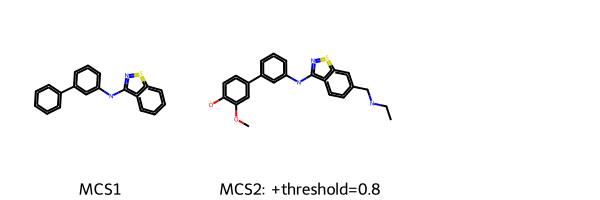

In [ ]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

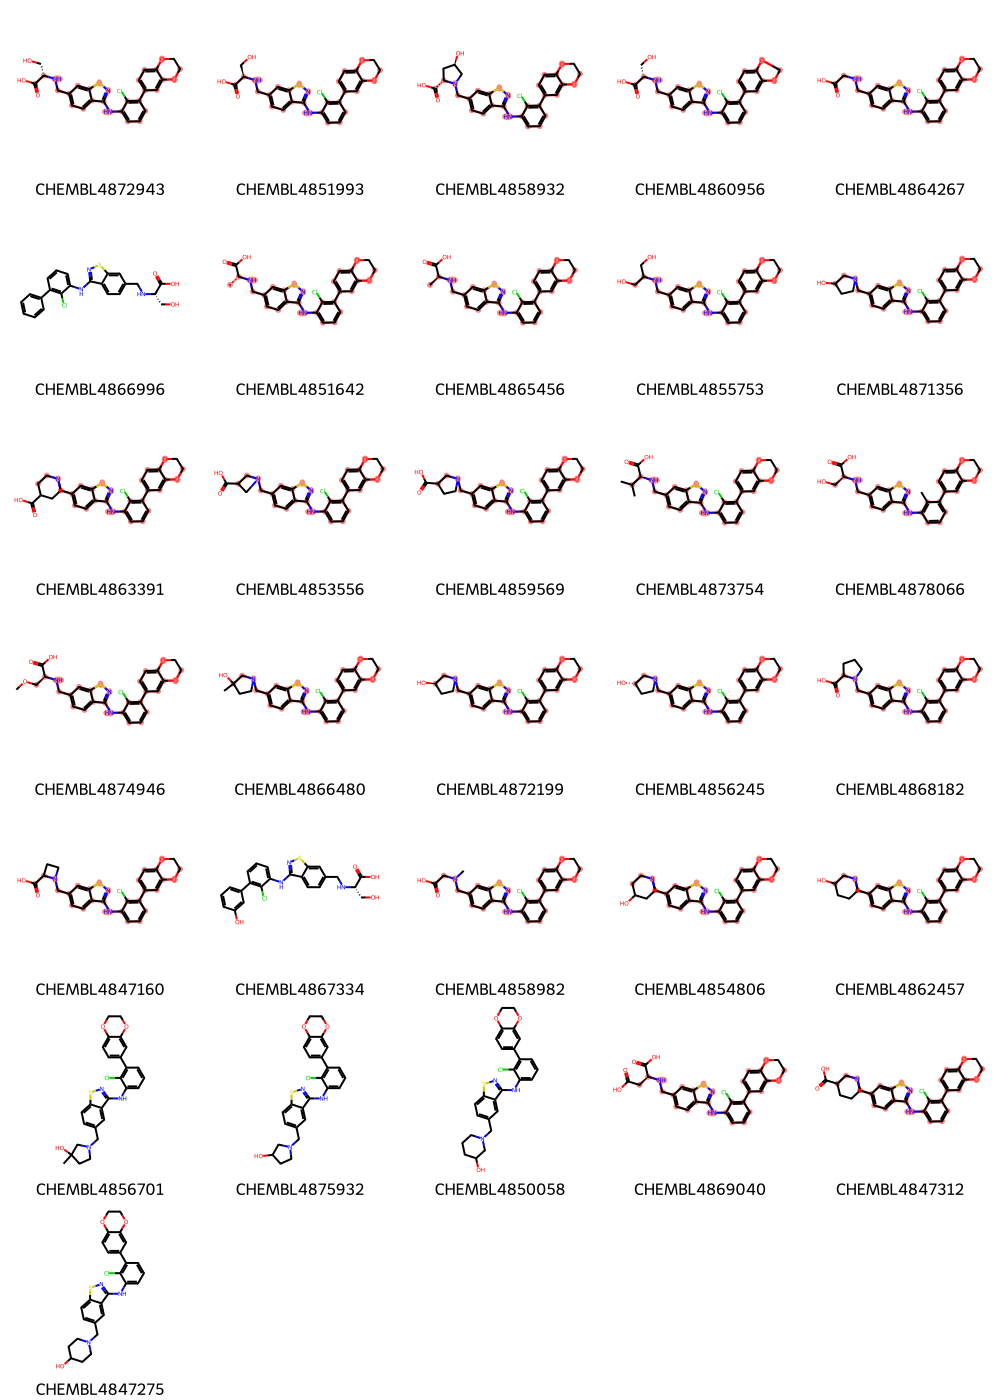

In [ ]:
highlight_molecules(mols, mcs2, 46)

Match Ring Bond

In [ ]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

MCS3 contains 27 atoms and 31 bonds.
SMARTS string: [#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]2:&@[#6&R](:&@[#6&R]:&@1):&@[#16&R]:&@[#7&R]:&@[#6&R]:&@2-&!@[#7&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@1-&!@[#17&!R])-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]2:&@[#6&R](:&@[#6&R]:&@1)-&@[#8&R]-&@[#6&R]-&@[#6&R]-&@[#8&R]-&@2


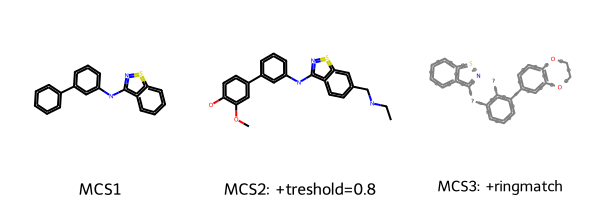

In [ ]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "MCS3: +ringmatch"])

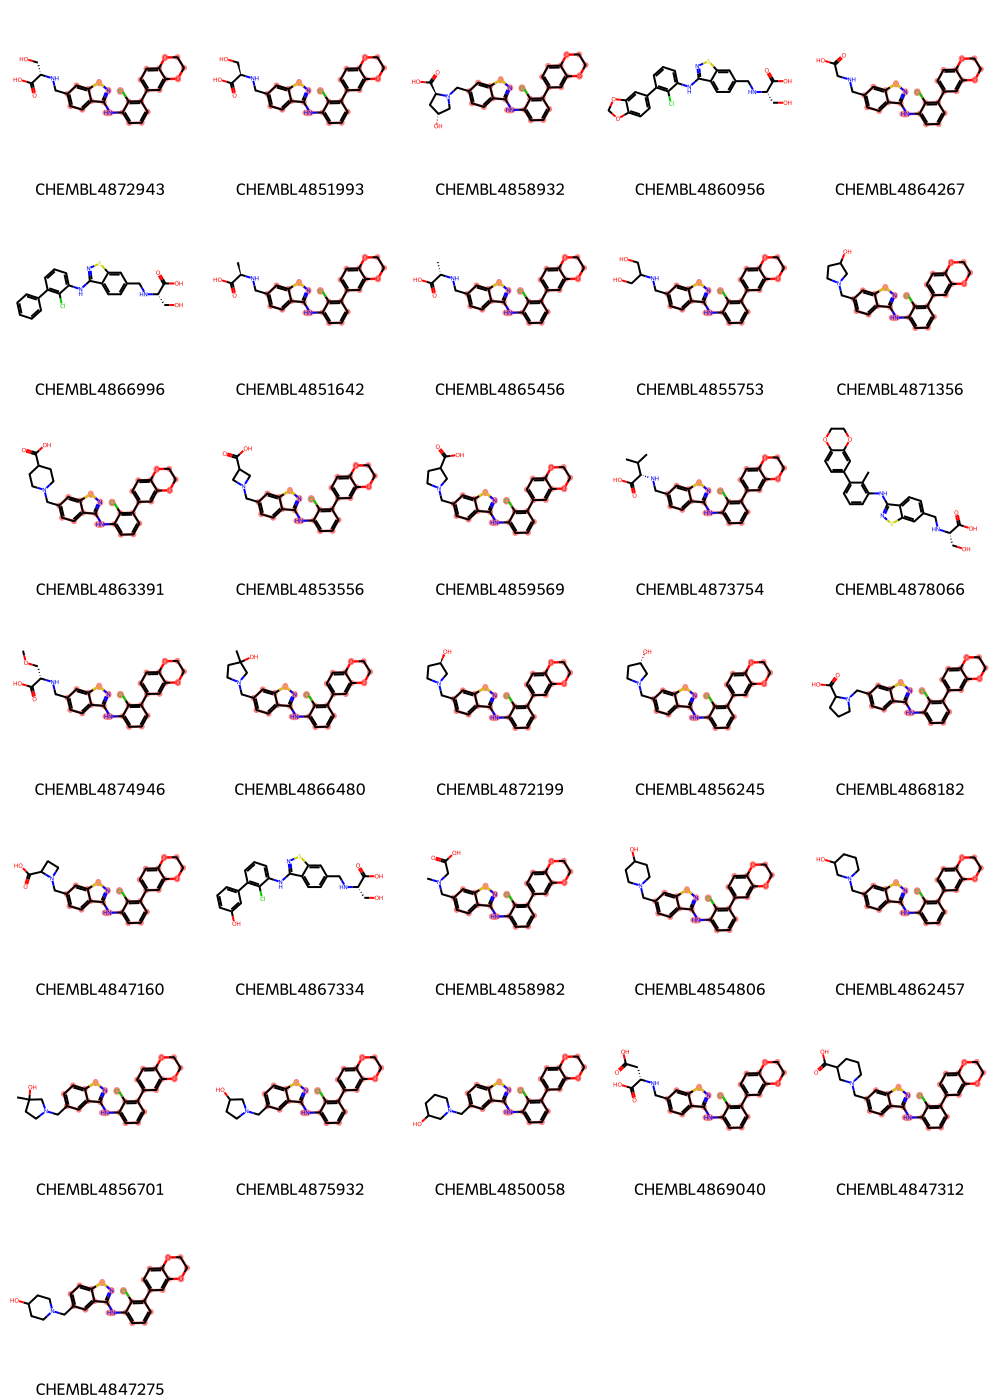

In [ ]:
highlight_molecules(mols, mcs3, 46)